# 教程一

这个notebook假设读者已经了解了python的基本语法和arma的算法逻辑，对于这部分只会进行简单的解释。  
我们将着重介绍的是如何用python来运用arma对数据集进行分析。  
  
[数据集详情地址](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)
本教程的数据集存放在同级目录下的data文件夹中。  

下面的文档可能对于不够熟悉python的读者来说会有帮助，在遇到困难的时候，查阅文档或者询问搜索引擎是很有帮助的。  
* [pyhton的简易入门教程](https://www.liaoxuefeng.com/wiki/0014316089557264a6b348958f449949df42a6d3a2e542c000)
* [python中文文档](https://docs.python.org/zh-cn/3/tutorial/index.html)
* [python的一些常用技巧](https://python3-cookbook.readthedocs.io/zh_CN/latest/index.html)

更多的信息可以查阅numpy，pandas的手册  
……  
这次实验的目的是通过对股票交易数据集的分析……………………


## 1. 引入包
引入别人的包可以减少自己的工作量，numpy是……matplotlib是绘图包……

In [2]:
# 引入各种需要的包
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib
import matplotlib.pylab as plt
# import matplotlib.finance as mpf
import mpl_finance as mpf
from matplotlib.pylab import rcParams
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
from tqdm import tqdm
import statsmodels.api as sm

# 检查文件夹下的文件列表
print(check_output(["ls", "./Data"]).decode("utf8"))

# 使用seaborn风格的绘图风格，并使图像内嵌到notebook中
matplotlib.style.use('seaborn')
%matplotlib inline
# 规定绘图大小
rcParams['figure.figsize'] = 15, 5
init_notebook_mode()

CalledProcessError: Command '['ls', './Data']' returned non-zero exit status 2.

## 2. 准备数据
引入需要的包后，就可以读入数据并做一些简单的预处理。预处理是指由于我们的实验目的和数据集的内容经常产生冲突，这次用到的数据集内容过多，而可能有些数据集会有数据缺失等等现象，为了获得更加优质的数据，需要在实验前对数据集进行必要的处理。  

1. 读取文件到pandas的特有文件格式——dataframe，简称df，并查看前十行数据，open是开盘价格，high是当天最高市值，low是当天最低市值，close是收盘价格，volume是成交量，openint是是否开放购买（？）
2. 转换Date列的数据格式为datetime
3. 设置Date列为dataframe的索引
4. 计算当天收盘和上一天收盘价格的差，放在dataframe的最后一列。所有对dataframe的操作，都会作用到每一列每一行，所以不需要for循环去挨个计算
5. log1p(x)的作用是计算log(1 + x)（目的不明？）
6. 把我们关心的'Close', 'Close_diff', 'Close_diff_log'三列提取出来，并删掉无效数据，比如第1天的数据，这里可没有第0天的数据来计算收盘价格差值，最后看一下整理好的数据
7. 用分片的技巧，把2015-01-01到2017-01-01的数据提取出来作为训练集，其他的做测试集，观察两者大小

In [46]:
df = pd.read_csv('./Data/Stocks/goog.us.txt')
print(df.head(10))
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df['Close_diff'] = df['Close']-df.shift()['Close']
df['Close_diff_log'] = np.log1p(df['Close'])-np.log1p(df.shift()['Close'])

df = df[['Close', 'Close_diff', 'Close_diff_log']]
df = df.dropna()
print(df.head(10))
train = df['2015-01-01':'2017-01-01']
test = df['2017-01-01':]

print('\n', len(train), len(test))

         Date    Open    High     Low   Close   Volume  OpenInt
0  2014-03-27  568.00  568.00  552.92  558.46    13052        0
1  2014-03-28  561.20  566.43  558.67  559.99    41003        0
2  2014-03-31  566.89  567.00  556.93  556.97    10772        0
3  2014-04-01  558.71  568.45  558.71  567.16     7932        0
4  2014-04-02  599.99  604.83  562.19  567.00   146697        0
5  2014-04-03  569.85  587.28  564.13  569.74  5087500        0
6  2014-04-04  574.65  577.77  543.00  543.14  6377600        0
7  2014-04-07  540.74  548.48  527.15  538.15  4368717        0
8  2014-04-08  543.07  555.00  541.61  554.90  3148563        0
9  2014-04-09  559.77  565.37  552.95  564.14  3323579        0
             Close  Close_diff  Close_diff_log
Date                                          
2014-03-28  559.99        1.53        0.002731
2014-03-31  556.97       -3.02       -0.005398
2014-04-01  567.16       10.19        0.018098
2014-04-02  567.00       -0.16       -0.000282
2014-04-03  56

## 绘制图像
下面介绍如何用plotly包里的iplot来进行绘制，注意上面已经引入了iplot，这里才可以直接使用，否则需要写作plotly.offline.iplot。  
1. 首先绘制的是横轴为Date，纵轴为Close_diff的散点图，表现了每天股价的涨跌情况。  
2. 然后是Close_diff的直方图，可以看出Close_diff的分布情况。  
3. 最后画出acf图和pacf图（？）。  

这里可以看出python的方便，只要别人写过，我们就可以很方便地使用，只需要查阅别人的使用说明文档就可以了，
比如这个statsmodels包里的plot_acf有些参数我不知道怎么写，但是我们可以到他们的[官方文档](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html?highlight=plot_acf#statsmodels.graphics.tsaplots.plot_acf)
处查找。  
同样的，通过修改iplot的参数，可以画出任何你想要的图像，详见[官方网站](https://plot.ly/python/)。比如将第二行的x改成y，将出现横着的直方图，Histogram方法里面加入opacity=0.5可以让图像半透明，在[]中加入Histogram(x=test['Close_diff'])可以把测试集的数据用黄色画上去，再加上修改Layout，可以将两组数据重叠或者堆叠在一起……只要你敢于想象，乐于搜索。

In [1]:
iplot([Scatter(x=train.index, y=train['Close_diff'])])

NameError: name 'iplot' is not defined

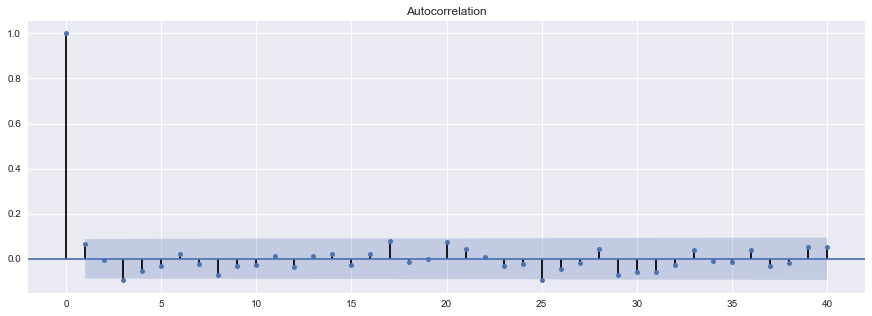

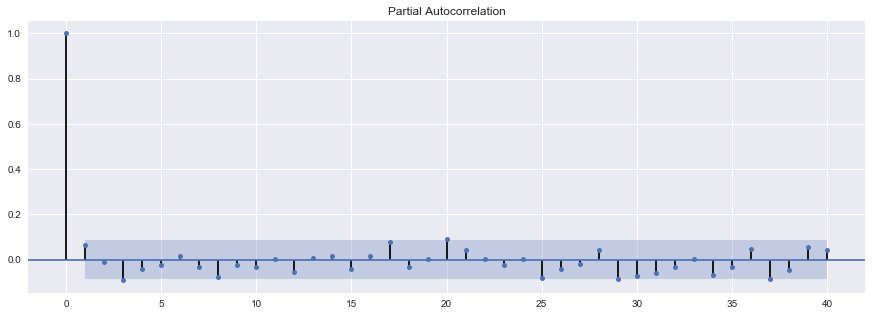

In [74]:
iplot([Scatter(x=train.index, y=train['Close_diff'])])
iplot([Histogram(x=train['Close_diff'])])
plt = sm.graphics.tsa.plot_acf(train['Close_diff'], lags=40)
plt = sm.graphics.tsa.plot_pacf(train['Close_diff'], lags=40)

In [61]:
res = sm.tsa.arma_order_select_ic(train['Close_diff'], ic='aic', trend='nc')
res

In [62]:
from statsmodels.tsa.arima_model import ARIMA

arima_3_1_0 = ARIMA(train['Close'].as_matrix(), order=(3, 1, 0)).fit(dist=False)
arima_3_1_0.params

array([ 0.49681479,  0.06339131, -0.00468575, -0.09166228])

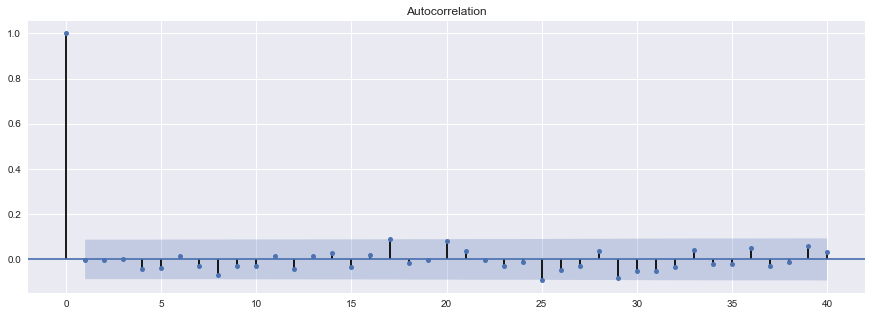

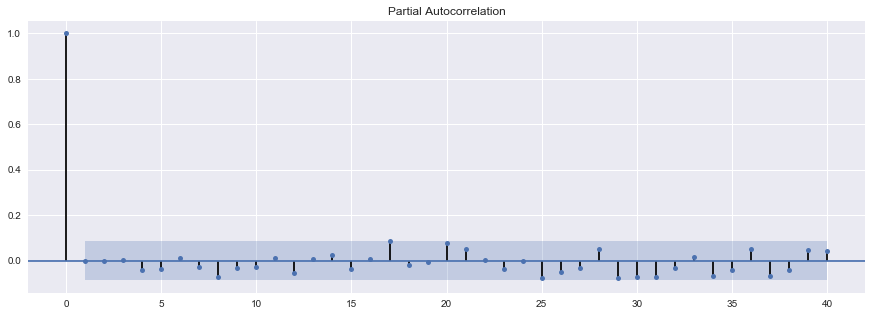

In [63]:
plt = sm.graphics.tsa.plot_acf(arima_3_1_0.resid, lags=40)
plt.show()
plt = sm.graphics.tsa.plot_pacf(arima_3_1_0.resid, lags=40)
plt.show()

In [32]:
ts = train['Close'].as_matrix()
predictions = np.empty((0), dtype=np.float32)
n_pre = 100
for i in tqdm(range(n_pre)):
    arima_3_1_0 = ARIMA(ts, order=(3, 1, 0)).fit(dist=False)
    predict = arima_3_1_0.forecast()[0]
    predictions = np.hstack([predictions, predict])
    ts = np.hstack([ts, predict])

100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


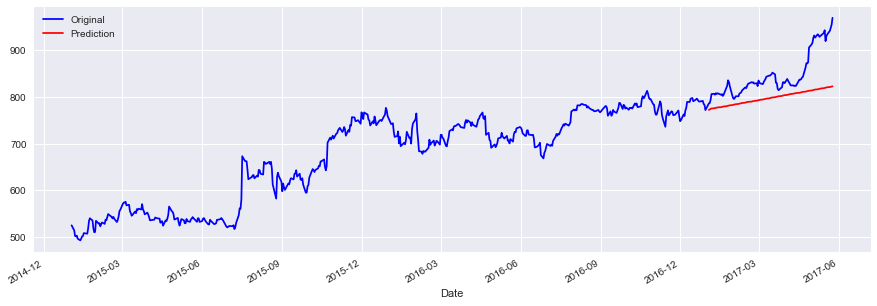

In [33]:
nans = np.zeros(len(train))
nans[:] = np.nan
orgs = pd.concat([train['Close'], test[:n_pre]['Close']])
orgs = pd.DataFrame({
    'Date': orgs.index,
    'Original': orgs.as_matrix(),
    'Prediction': np.hstack([nans, predictions])
})
orgs = orgs.set_index('Date')
orgs.plot(color=['blue', 'red'])
plt.show()

In [34]:
def search_param(path, start='2015-01-01', end='2017-01-01'):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df['Close_diff'] = df['Close']-df.shift()['Close']
    df = df[['Close', 'Close_diff']]
    df = df.dropna()
    train = df[start:end]
    test = df[end:]
    res = sm.tsa.arma_order_select_ic(train['Close_diff'], ic='aic', trend='nc')
    print(res)
    return train, test

In [35]:
def show_predict(train, test, n_pre, p, d, q):
    arima_init = ARIMA(train['Close'].as_matrix(), order=(p, d, q)).fit(dist=False)
    ts = train['Close'].as_matrix()
    predictions = np.empty((0), dtype=np.float32)
    for i in tqdm(range(n_pre)):
        arima = ARIMA(ts, order=(p, d, q)).fit(dist=False)
        predict = arima.forecast()[0]
        predictions = np.hstack([predictions, predict])
        ts = np.hstack([ts, predict])
    nans = np.zeros(len(train))
    nans[:] = np.nan
    orgs = pd.concat([train['Close'], test[:n_pre]['Close']])
    orgs = pd.DataFrame({
        'Date': orgs.index,
        'Original': orgs.as_matrix(),
        'Prediction': np.hstack([nans, predictions])
    })
    orgs = orgs.set_index('Date')
    orgs.plot(color=['blue', 'red'])
    plt.show()
    return arima_init

{'aic':              0            1            2
0          NaN  1953.795625  1954.468319
1  1953.826898  1953.863341  1955.597375
2  1954.543317  1955.459639          NaN
3  1955.956194  1957.252395  1955.438239
4  1956.257965  1958.255532  1954.898380, 'aic_min_order': (0, 1)}


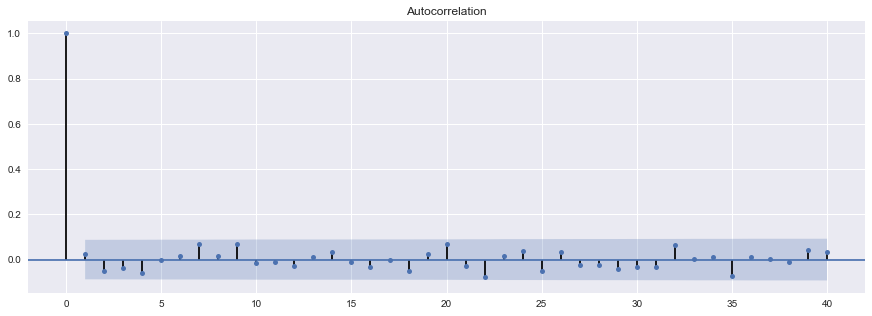

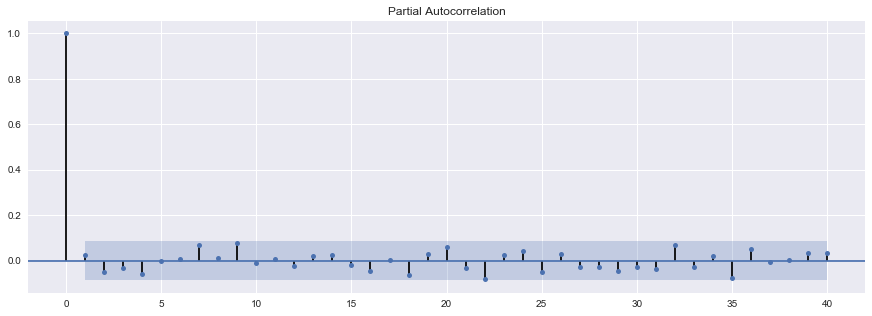

In [37]:
train, test = search_param('./Data/Stocks/aapl.us.txt')
plt = sm.graphics.tsa.plot_acf(train['Close_diff'], lags=40)
plt.show()
plt = sm.graphics.tsa.plot_pacf(train['Close_diff'], lags=40)
plt.show()

100%|██████████| 100/100 [00:02<00:00, 49.55it/s]


[0.02066982 0.02411342]


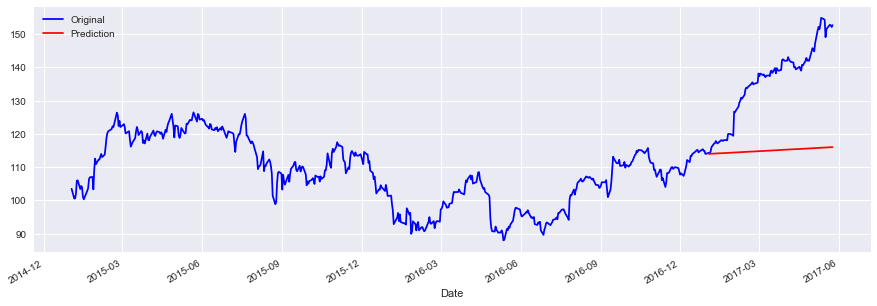

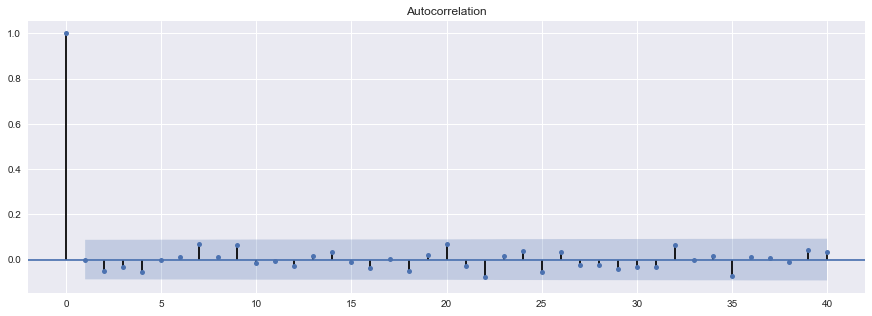

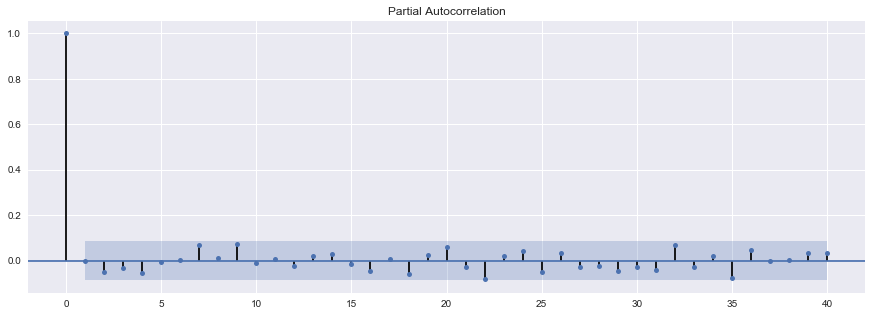

In [38]:
arima_0_1_1 = show_predict(train, test, 100, 0, 1, 1)
print(arima_0_1_1.params)
plt = sm.graphics.tsa.plot_acf(arima_0_1_1.resid, lags=40)
plt.show()
plt = sm.graphics.tsa.plot_pacf(arima_0_1_1.resid, lags=40)
plt.show()

In [39]:
train, test = search_param('./Data/Stocks/fb.us.txt')

{'aic':              0            1            2
0          NaN  1970.082192  1972.081892
1  1970.113225  1972.082147  1967.071280
2  1971.933599  1966.127930  1966.697541
3  1963.891762  1965.490664  1966.476734
4  1965.520080  1962.022958  1963.428219, 'aic_min_order': (4, 1)}


100%|██████████| 100/100 [00:35<00:00,  2.94it/s]


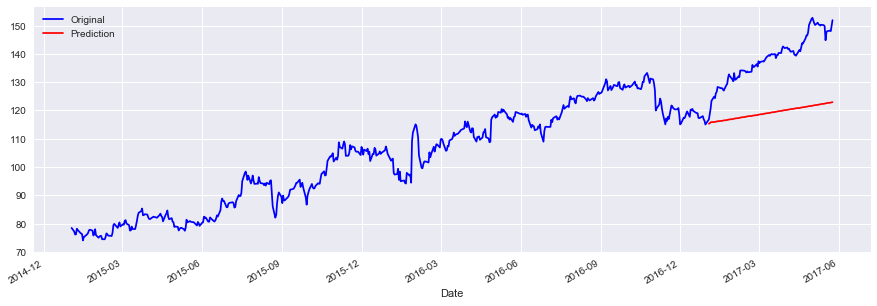

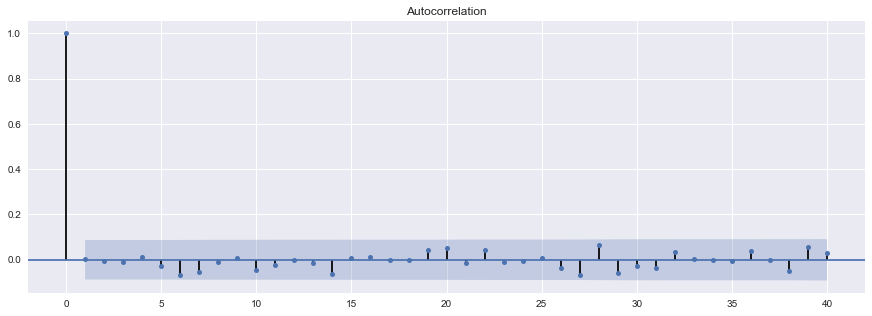

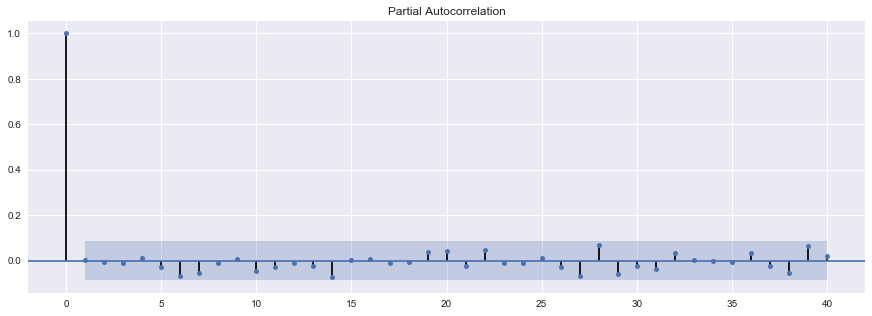

In [40]:
arima_4_1_1 = show_predict(train, test, 100, 4, 1, 1)
plt = sm.graphics.tsa.plot_acf(arima_4_1_1.resid, lags=40)
plt.show()
plt = sm.graphics.tsa.plot_pacf(arima_4_1_1.resid, lags=40)
plt.show()